In [1]:
# Import packages
%reload_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import scarlet

import kuaizi as kz
from kuaizi.display import display_single, display_rgb, SEG_CMAP
from kuaizi.detection import Data
from kuaizi.utils import padding_PSF

import unagi

import astropy.units as u
from astropy import wcs
from astropy.io import fits
from astropy.table import Table, Column, vstack
from astropy.coordinates import SkyCoord, match_coordinates_sky
from astropy.convolution import convolve, Gaussian2DKernel

In [3]:
from kuaizi.fit import ScarletFitter, fitting_obs_tigress

In [4]:
env_dict = {'project': 'HSC', 'name': 'LSBG', 'data_dir': '/scratch/gpfs/jiaxuanl/Data'}
kz.utils.set_env(**env_dict)
kz.utils.set_matplotlib(style='default', usetex=False)

In [5]:
lsbg_cat = Table.read('./Catalog/mock_sample/mock_obj_cat_0_5000.fits')
print('# of LSBGs:', len(lsbg_cat))
channels = 'griz'

# of LSBGs: 5000


In [12]:
ind = 33
lsbg = lsbg_cat[ind] # 12 # 69

In [13]:
import pickle
with open(f'./Cutout/mock_sample/mock_{ind}.pkl', 'rb') as f:
    mock_gal = pickle.load(f)

In [14]:
prefix = 'LSBG'
channels = 'griz'
index = lsbg['viz-id']

bright = (lsbg['mag_auto_i'] < 17.5)
print('Bright =', bright)

lsbg_coord = SkyCoord(ra=lsbg['ra'], dec=lsbg['dec'], unit='deg')

weights = 1.0 / mock_gal.mock.variances
weights[np.isinf(weights)] = 0.0

psfs = scarlet.ImagePSF(np.array(mock_gal.mock.psfs))

data = Data(images=mock_gal.model.images, 
            weights=weights, masks=mock_gal.mock.masks,
            wcs=mock_gal.mock.wcs, psfs=psfs, 
            channels=mock_gal.mock.channels)

Bright = False


In [15]:
fitter = ScarletFitter(method='spergel', tigress=True, bright=bright,
                       min_grad=-0.05, thresh=0.1, bkg=False,
                       model_dir='./Model/mock_test/',
                       figure_dir='./Figure/mock_test',
                       log_dir='./log/mock_test',
                       prefix='mock', 
                       index=lsbg['viz-id'], 
                       show_figure=True)
fitter.load_data(data, lsbg_coord)

In [ ]:
fitter.fit_pure_mock()

  - Detect sources and make mask
    Query GAIA stars...
    Taking Gaia catalogs stored in `Tigress`
    8 stars from Gaia are masked!
    Detected 1 objects
    5 stars from Gaia are masked!
  - Added Spergel profile with bbox = (4, 715, 715)
  - Optimizing scarlet model...
    Optimizaiton: Succeed for e_rel = 0.0001 with 44 iterations! Try higher accuracy!


In [ ]:
from kuaizi.measure import cal_cnu
david = fitter._blend.sources[0]
print(david.get_parameter(3) * 0.168, mock_gal.model.info['comp'][0]['model_params']['half_light_radius'])
sed, morph = david.get_models_of_children()
true_flux = (2 * np.pi * david.parameters[3]**2) / cal_cnu(david.parameters[2])**2
print('mag:', -2.5 * np.log10(true_flux * sed) + 27.0)
print('Truth mag:', [mock_gal.model.info[f'{filt}mag'] for filt in list('griz')])
# print('Sky:', -2.5 * np.log10(fitter.blend.sources[-1].get_model().mean(axis=(1, 2)) / 0.168**2) + 27)

#### Step-by-step

In [112]:
fitter._first_gaia_search()

    Query GAIA stars...
    Taking Gaia catalogs stored in `Tigress`
    10 stars from Gaia are masked!


In [113]:
# Set the weights of saturated star centers to zero
# In order to make the box size estimation more accurate.
temp = np.copy(fitter.data.masks)
for i in range(len(fitter.data.channels)):
    temp[i][~fitter.msk_star_ori.astype(bool)] = 0
    fitter.data.weights[i][temp[i].astype(bool)] = 0.0

    Detected 1 objects


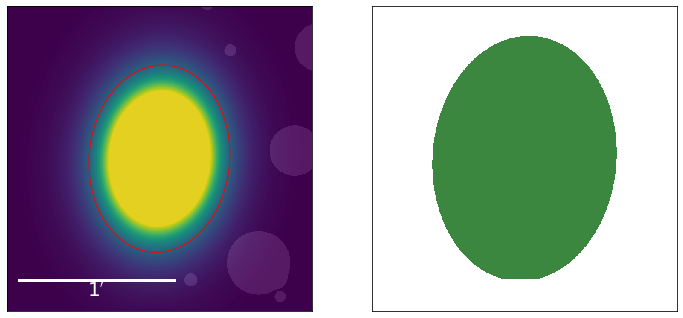

In [114]:
# Replace the vanilla detection with a convolved vanilla detection
first_dblend_cont = 0.07 if max(
    fitter.data.images.shape) * fitter.pixel_scale > 200 else 0.002

if fitter.method == 'wavelet':
    first_dblend_cont = 0.07 if max(
    fitter.data.images.shape) * fitter.pixel_scale > 200 else 0.002
        
fitter._first_detection(first_dblend_cont, conv_radius=0.1, lvl=5, b=fitter.data.images.shape[-1])

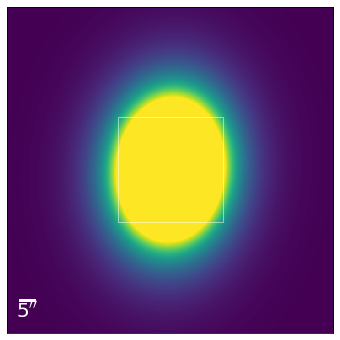

In [115]:
fitter._estimate_box(fitter.cen_obj)

In [116]:
fitter._mask_stars_outside_box()

    10 stars from Gaia are masked!


In [93]:
# fitter._cpct_obj_detection(high_freq_lvl=4)

In [94]:
# from kuaizi.display import draw_circles

In [95]:
# fitter._big_obj_detection()

In [96]:
# fitter._merge_catalogs()

In [117]:
fitter._construct_obs_frames()

In [118]:
fitter._add_central_source(min_grad=fitter.min_grad, thresh=0.1)
fitter.blend = scarlet.Blend(fitter._sources, fitter.observation)
# fitter._add_other_sources(min_grad=0.1, thresh=0.1)

  - Added Spergel profile with bbox = (4, 572, 572)


[<AxesSubplot:title={'center':'Data'}>,
 <AxesSubplot:title={'center':'Model'}>,
 <AxesSubplot:title={'center':'Residual'}>]

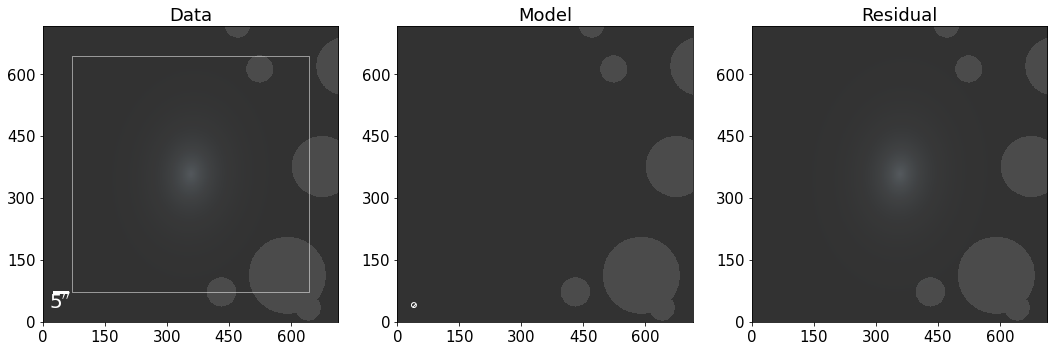

In [119]:
kz.display.display_scarlet_model(
    fitter.blend,
#     show_ind=[0],
    #zoomin_size=50,
    minimum=-0.2,
    stretch=0.9,
    add_boxes=True,
    channels='griz',
    show_mask=False,
    show_mark=False, 
    show_loss=False)

  - Optimizing scarlet model...
    Optimizaiton: Succeed for e_rel = 0.0001 with 56 iterations! Try higher accuracy!
    Optimizaiton: Succeed for e_rel = 0.0005 with 96 iterations! Try higher accuracy!
    Optimizaiton: Succeed for e_rel = 0.0002 with 116 iterations! Try higher accuracy!
  - After 116 iterations, logL = 3430208.18
    Elapsed time for fitting: 136.52 s


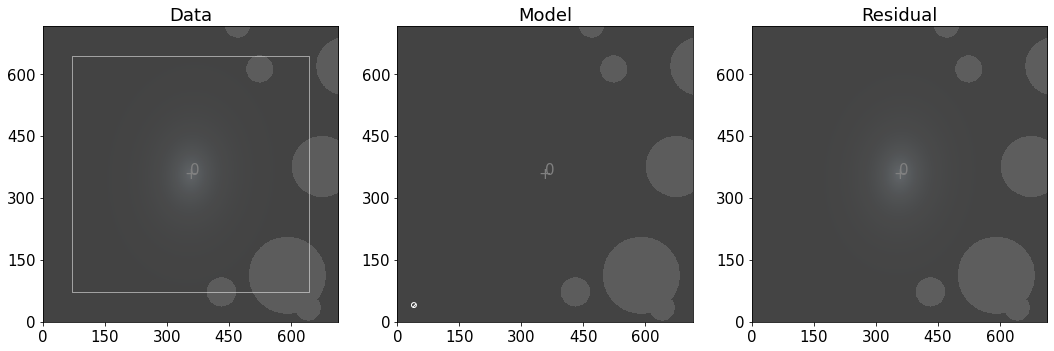

In [120]:
fitter._optimize()

In [136]:
try:
    fitter._find_sed_ind()
    fitter._gen_final_mask()
    fitter._display_results()
except:
    pass

  - Components [0] are considered as the target galaxy.
  - Masking stars and other sources that are modeled, to deal with leaky flux issue.


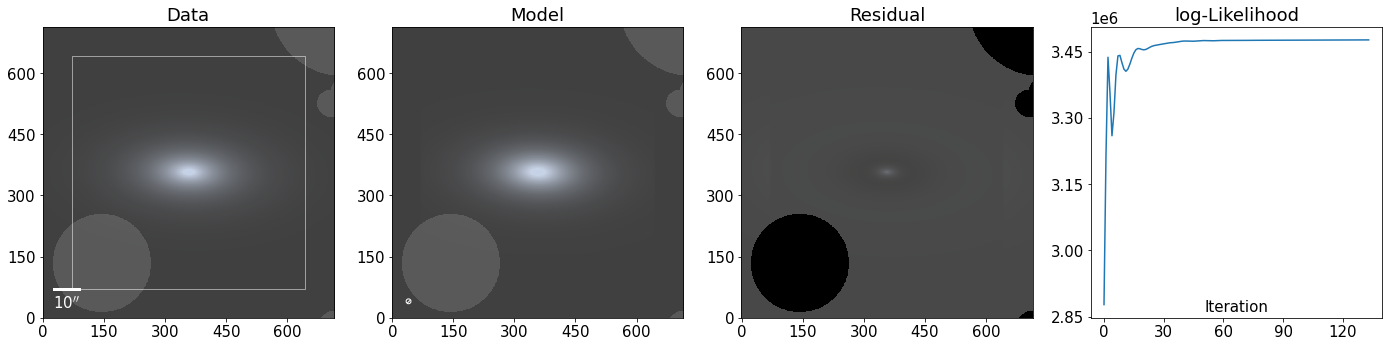

In [137]:
fig = kz.display.display_scarlet_results_tigress(
        fitter._blend,
#         fitter.final_mask,
#         show_ind=fitter.sed_ind,
#         zoomin_size=50,
        minimum=-0.2,
        stretch=0.7,
        Q=1,
        channels=fitter.data.channels,
        show_loss=True,
        show_mask=False,
        show_mark=False,
        scale_bar=True)

In [138]:
from kuaizi.measure import cal_cnu
david = fitter.blend.sources[0]
print(david.get_parameter(3) * 0.168)
sed, morph = david.get_models_of_children()
true_flux = (2 * np.pi * david.parameters[3]**2) / cal_cnu(david.parameters[2])**2
print('mag:', -2.5 * np.log10(true_flux * sed) + 27.0)
print('Sky:', -2.5 * np.log10(fitter.blend.sources[-1].get_model().mean(axis=(1, 2)) / 0.168**2) + 27)
mock_gal.model.info

[[13.10659906]]
mag: [[17.63688009 17.28253569 17.13489125 17.04306567]]
Sky: [27.57471233 27.22036794 27.0727235  26.98089792]


[<AxesSubplot:title={'center':'Background'}>,
 <AxesSubplot:title={'center':'Mock Image'}>,
 <AxesSubplot:title={'center':'Model'}>]

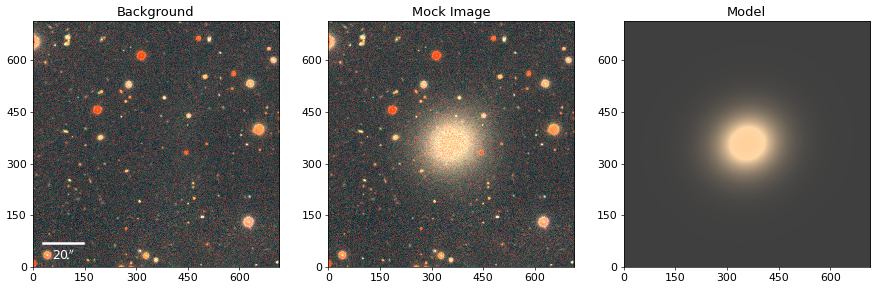

In [44]:
import pickle

with open(f'./Cutout/mock_sample/mock_{lsbg["viz-id"]}.pkl', 'rb') as fp:
    gal = pickle.load(fp)
gal.display(stretch=0.8)

In [91]:
from kuaizi.measure import nu_to_n

In [ ]:
nu_to_n(david.parameters[2]), gal.model.info['comp'][0]['model_params']['n']

In [ ]:
david.parameters[3] * 0.168, gal.model.info['comp'][0]['model_params']['half_light_radius']

In [100]:
from kuaizi.measure import makeMeasurement, makeMeasurementMockGal

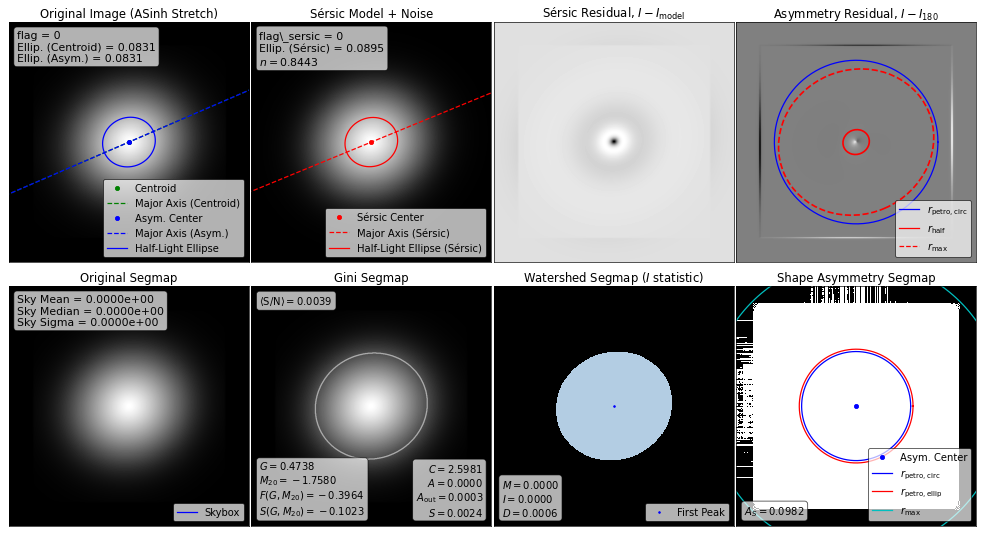

In [47]:
measurement, t = makeMeasurement(list(np.array(fitter.blend.sources)[fitter.sed_ind]),
                                 fitter.blend.observations[0],
                                 aggr_mask=fitter.final_mask.astype(bool),
                                 makesegmap=False, sigma=0.02,
                                 method='spergel',
                                 zeropoint=27.0, out_prefix=None,
                                 show_fig=True, asinh_a=0.02, framealpha=0.7)
#row = _write_to_row(row, measurement)

In [102]:
# Sky SB
-2.5 * np.log10(fitter.blend.sources[-1].get_model().mean(axis=(1, 2)) / 0.168**2) + 27

Parameter([29.4934964 , 28.74595229, 28.74534842, 28.11704383])

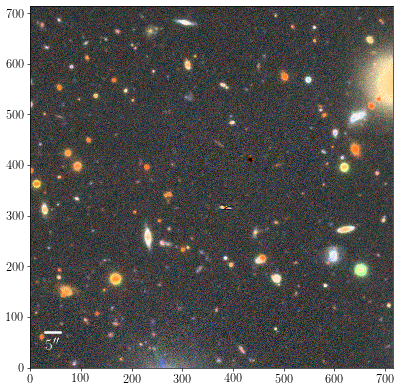

In [142]:
display_rgb(gal.mock.images - fitter.observation.render(fitter.blend.get_model()), stretch=0.8);

In [104]:
print(measurement['rhalf_circularized'] * 0.168)
print(gal.model.info['comp'][0]['model_params']['half_light_radius'])
measurement['sersic_rhalf'] * 0.168 * np.sqrt(1 - measurement['ellipticity_asymmetry'])

4.914961939897793
4.556496604388463


5.068036433903733

In [105]:
measurement['SB_eff_avg'], measurement['mag']

(array([25.790022, 25.45826 , 25.405367, 25.216639], dtype=float32),
 array([20.323706, 19.991943, 19.93905 , 19.75032 ], dtype=float32))

In [106]:
-2.5 * np.log10(measurement['flux_circ']) + 27

array([20.344858, 20.013096, 19.960203, 19.771473], dtype=float32)

In [107]:
gal.model.info['gmag'], gal.model.info['rmag'], gal.model.info['imag']

(20.420431085096865, 20.089120531929915, 19.987150741690147)

In [108]:
measurement['ellipticity_asymmetry'], 1 - gal.model.info['comp'][0]['shear_params']['q']

(0.12251074353348768, 0.1277100516230144)

In [9]:
import dill
from kuaizi.measure import makeMeasurement, makeMeasurementMockGal

[<AxesSubplot:title={'center':'Data'}>,
 <AxesSubplot:title={'center':'Model'}>,
 <AxesSubplot:title={'center':'Residual'}>,
 <AxesSubplot:title={'center':'log-Likelihood'}, xlabel='Iteration'>]

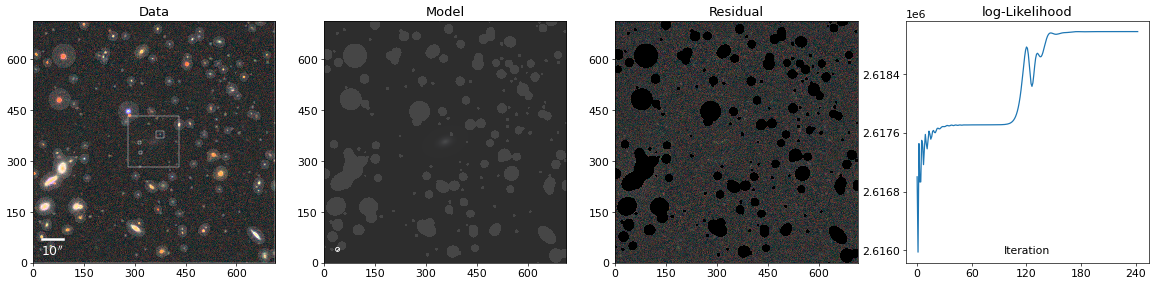

In [98]:
ind = 8
method = 'spergel'
# method = 'vanilla'
with open(f'./Model/mock_sample/spergel/mock-{ind}-trained-model-{method}.df', "rb") as fp:
    blend, info, mask = dill.load(fp)
    fp.close()
    
kz.display.display_scarlet_results_tigress(
    blend,
    mask,
    show_ind=[0],
    #zoomin_size=50,
    minimum=-0.2,
    stretch=1,
    add_boxes=True,
    channels='griz',
    show_mask=False,
    show_mark=False, 
    show_loss=True)

In [52]:
print(blend.sources[0].bbox)

<Box shape=(4, 187, 187), origin=(0, 264, 268)>


In [53]:
from kuaizi.measure import cal_cnu
david = blend.sources[0]
print(david.get_parameter(3) * 0.168)
sed, morph = david.get_models_of_children()
true_flux = (2 * np.pi * david.parameters[3]**2) / cal_cnu(david.parameters[2])**2
-2.5 * np.log10(true_flux * sed) + 27.0

[[7.40730267]]


Parameter([[19.87761432, 19.55323591, 19.35940279, 19.30085134]])

[<AxesSubplot:title={'center':'Background'}>,
 <AxesSubplot:title={'center':'Mock Image'}>,
 <AxesSubplot:title={'center':'Model'}>]

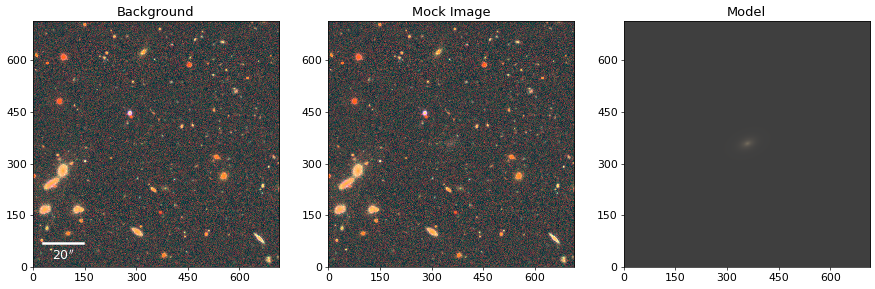

In [99]:
import pickle

with open(f'./Cutout/mock_sample/mock_{ind}.pkl', 'rb') as fp:
    gal = pickle.load(fp)
gal.display(stretch=0.8)

In [100]:
output_dir = '/scratch/gpfs/jiaxuanl/Data/HSC/LSBG/Cutout/mock_test/'
gal.write_fits_model(output_dir=output_dir,
                prefix='mock',
                obj_id=ind,
                overwrite=True)

In [17]:
src = blend.sources[0]

In [18]:
sed, morph = src.get_models_of_children()

In [23]:
from kuaizi.measure import cal_cnu

In [24]:
true_flux = (2 * np.pi * src.parameters[3]
             ** 2) / cal_cnu(src.parameters[2])**2

In [25]:
true_flux

Parameter([[2281.71784862]])

In [ ]:

measure_dict['flux'] = np.array(true_flux * sed).ravel()

In [15]:
measurement['mag'] + 2.5 * np.log10(2 * np.pi * 5.29124731838925**2)

array([25.68790056, 25.17335591, 24.890307  , 24.7395501 ])

In [13]:
measurement

{'flux': array([ 589.02776564,  946.13613239, 1227.9288129 , 1410.83411416]),
 'mag': array([20.07466058, 19.56011593, 19.27706702, 19.12631012]),
 'xc_centroid': 357.1417046352392,
 'yc_centroid': 357.2510046552573,
 'xc_peak': 357,
 'yc_peak': 357,
 'ellipticity_centroid': 0.3166487822744145,
 'elongation_centroid': 1.4633763342492085,
 'orientation_centroid': 1.2173937606813743,
 'xc_asymmetry': 357.09274031872377,
 'yc_asymmetry': 357.1181498081936,
 'ellipticity_asymmetry': 0.3166544769087113,
 'elongation_asymmetry': 1.4633885292410251,
 'orientation_asymmetry': 1.217393769881961,
 'rpetro_circ': 69.94761766006506,
 'rpetro_ellip': 82.34551445847171,
 'rhalf_circ': 31.04244076068336,
 'rhalf_ellip': 36.70931702963555,
 'rhalf_circularized': 30.34565257827869,
 'rhalf_spergel': 31.495519752316966,
 'r20': 15.32360043870817,
 'r50': 30.949788953565008,
 'r80': 54.08800357963841,
 'SB_0_circ': array([24.73551487, 24.22097022, 23.93792131, 23.78716441]),
 'SB_0_ellip': array([24.7355

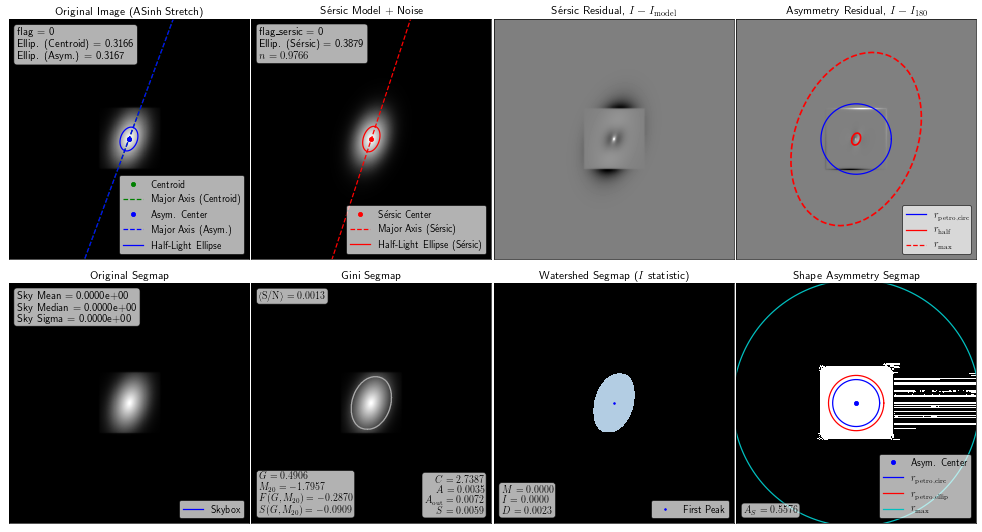

In [12]:
measurement, t = makeMeasurement(list(np.array(blend.sources)[info['sed_ind']]),
                                 blend.observations[0],
                                 aggr_mask=mask.astype(bool),
                                 method='spergel',
                                 makesegmap=False, sigma=0.02,
                                 zeropoint=27.0, out_prefix=None,
                                 show_fig=True, asinh_a=0.02, framealpha=0.7)